In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import matplotlib as mpl

colourscheme = [
    (41, 78, 114),
    (166, 197, 234),
    (255, 165, 0),
    (243, 214, 176),
    (1, 105, 53),
    (192, 191, 135),
    (115, 59, 64),
    (216, 191, 216),
    (28, 29, 36),
    (203, 202, 208),
    (107, 107, 107),
    (246, 247, 246)
]
  
# Rescale to values between 0 and 1 
for i in range(len(colourscheme)):  
    r, g, b = colourscheme[i]  
    colourscheme[i] = (r / 255., g / 255., b / 255.)
    
new_rc_params = {
    'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}\usepackage{amsmath}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
}
mpl.rcParams.update(new_rc_params)
plt.rc('axes', axisbelow=True)

In [3]:
markers = ['x', 'o', 'd']

In [4]:
def diff_in_Qs_estimator_single_trajectory(a, r, propensities, control_variant, treatment_variant):
    Qs = np.cumsum(r[::-1])[::-1] 
    return np.sum(Qs * (a == treatment_variant) / propensities[treatment_variant] - Qs * (a == control_variant) / propensities[control_variant])
    
def diff_in_Qs_estimator(a, r, propensities, control_variant, treatment_variant):
    values = np.asarray([diff_in_Qs_estimator_single_trajectory(a_i, r_i, propensities, control_variant, treatment_variant) for a_i, r_i in zip(a,r)])
    return np.mean(values)

def diff_in_naive_estimator(a, r, propensities, control_variant, treatment_variant):
    return np.sum((np.concatenate(a) == treatment_variant) * np.concatenate(r) / propensities[treatment_variant] \
                - (np.concatenate(a) == control_variant) * np.concatenate(r) / propensities[control_variant]) / len(a)

def diff_in_geom_estimator(a, r, propensities, control_variant, treatment_variant):
    control_values = (np.concatenate(a) == control_variant) * np.concatenate(r) / propensities[control_variant]
    treatment_values = (np.concatenate(a) == treatment_variant) * np.concatenate(r) / propensities[treatment_variant]
    
    return 1.0 / (1.0 - np.mean(treatment_values)) - 1.0 / (1.0 -  np.mean(control_values))
    

def monte_carlo_estimator(r):
    values = np.asarray([np.sum(r_i) for r_i in r])
    return np.mean(values), np.std(values)

def diff_monte_carlo_estimator(r0, r1):
    mu0, std0 = monte_carlo_estimator(r0)
    mu1, std1 = monte_carlo_estimator(r1)

    # Make the assumption that covariance is 0 (which it should be)
    return mu1 - mu0, np.sqrt(std0**2 + std1**2)

## Higher-order-DAU Example

In [5]:
propensities = np.asarray([0.5, 0.25, 0.25])
expected_R = np.asarray([0.1, 0.2, 0.3])

In [6]:
def generate_data(N, propensities, expected_R):
    # Synthetic higher-order-DAU example
    actions = []
    rewards = []
    
    # For N trajectories
    for _ in range(N):

        actions_this = []
        rewards_this = []

        while True:
            
            # Sample action: is this user in C or T?            
            variant = rng.choice(len(propensities), p=propensities)
            
            # Sample reward (indicating whether a user shares)
            # Just assume that the probability of bringing in 2nd order DAU is higher under the treatment
            
            r = rng.random() < expected_R[variant]
 
            # Add to sequence for this trajectory
            actions_this.append(variant)
            rewards_this.append(r)

            if not r:
                break
                        
        # Add to all trajectories
        actions.append(np.asarray(actions_this))
        rewards.append(np.asarray(rewards_this))

    return actions, rewards

In [7]:
expected_higherorder_sessions = lambda gamma: 1.0 / (1.0 - gamma) - 1.0
expected_secondorder_sessions = lambda gamma: gamma

expected_higherorder_increase = lambda gamma: gamma**2 / (1.0 - gamma)

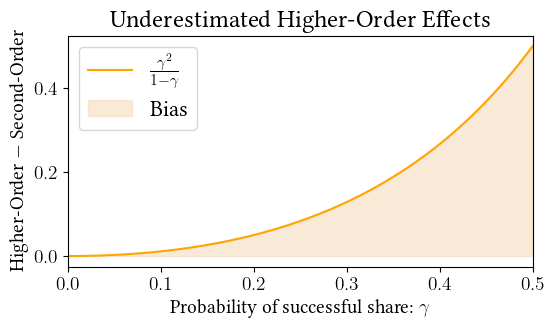

In [8]:
fontsize=18
fig, ax = plt.subplots(figsize=(6, 3))

max_gamma = 0.5
gammas = np.linspace(0.0, max_gamma, 100)

plt.title('Underestimated Higher-Order Effects', fontsize=fontsize)

plt.plot(gammas ,expected_higherorder_increase(gammas), color=colourscheme[2], label=r'$\frac{\gamma^{2}}{1-\gamma}$')
plt.fill_between(gammas, 0.0, expected_higherorder_increase(gammas), color=colourscheme[3], alpha=.5, label='Bias')


plt.xlabel(r'Probability of successful share: $\gamma$', fontsize=fontsize-4)
plt.ylabel(r'Higher-Order $-$ Second-Order', fontsize=fontsize-4)

plt.xlim(0.0, max_gamma)


ax.xaxis.set_tick_params(labelsize=fontsize-4)            
ax.yaxis.set_tick_params(labelsize=fontsize-4)

plt.legend(fontsize=fontsize-2)

plt.savefig('HO_effects.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# X-axis: sample size
# Y-axis: MSE of treatment effect
# 3 columns: 0-1, 0-2, 1-2

rng = np.random.default_rng(42)

# Ns = np.logspace(1,6,12, dtype=np.int64)
Ns = np.logspace(2,6,12, dtype=np.int64)

Ns = np.logspace(2,6,8, dtype=np.int64)
n_iter = 32

# Ns = np.logspace(2,4,5, dtype=np.int64)
# n_iter = 5

fontsize=18
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(14, 3))

for ax, (control_variant, treatment_variant) in zip(axes, [(0,1), (0,2), (1,2)]):
    
    # Ground truth
    ATE = expected_higherorder_sessions(expected_R[treatment_variant]) - expected_higherorder_sessions(expected_R[control_variant])
    
    N_MSE = []
    DQ_MSE = []
    DG_MSE = []

    N_SE_stderr = []
    DQ_SE_stderr = []
    DG_SE_stderr = []
    
    # For every data size
    for N in tqdm(Ns):
        
        N_err = []
        DQ_err = []
        DG_err = []
        
        for _ in range(n_iter):
            A, R = generate_data(N, propensities, expected_R)

            naive_mu = diff_in_naive_estimator(A, R, propensities, control_variant, treatment_variant)    
            N_err.append((naive_mu - ATE)**2)

            DQ_mu = diff_in_Qs_estimator(A, R, propensities, control_variant, treatment_variant)  
            DQ_err.append((DQ_mu - ATE)**2)

            DG_mu = diff_in_geom_estimator(A, R, propensities, control_variant, treatment_variant)  
            DG_err.append((DG_mu - ATE)**2)
            
            
        N_MSE.append(np.mean(N_err))
        DQ_MSE.append(np.mean(DQ_err))       
        DG_MSE.append(np.mean(DG_err))        

        N_SE_stderr.append(np.std(N_err) / np.sqrt(n_iter))
        DQ_SE_stderr.append(np.std(DQ_err) / np.sqrt(n_iter))       
        DG_SE_stderr.append(np.std(DG_err) / np.sqrt(n_iter))        

    N_MSE, N_SE_stderr = np.asarray(N_MSE), np.asarray(N_SE_stderr)
    DQ_MSE, DQ_SE_stderr = np.asarray(DQ_MSE), np.asarray(DQ_SE_stderr)
    DG_MSE, DG_SE_stderr = np.asarray(DG_MSE), np.asarray(DG_SE_stderr)
    
    ax.set_title(r'$\widehat{V}_{\Delta}(a_{'+f'{treatment_variant}'+'},a_{'+f'{control_variant}'+'})$', fontsize=fontsize)
    ax.plot(Ns, N_MSE, label=r'Na\"ive', color=colourscheme[6], marker=markers[0])    
    ax.fill_between(Ns, N_MSE-1.96*N_SE_stderr,  N_MSE+1.96*N_SE_stderr, alpha=.25, color=colourscheme[6])
    
    ax.plot(Ns, DQ_MSE, label='Differences-in-Qs', color=colourscheme[2], marker=markers[1])    
    ax.fill_between(Ns, DQ_MSE-1.96*DQ_SE_stderr,  DQ_MSE+1.96*DQ_SE_stderr, alpha=.25, color=colourscheme[2])

    ax.plot(Ns, DG_MSE, label='Differences-in-Geometrics', color=colourscheme[4], marker=markers[2])        
    ax.fill_between(Ns, DG_MSE-1.96*DG_SE_stderr,  DG_MSE+1.96*DG_SE_stderr, alpha=.25, color=colourscheme[4])

    if ax == axes[0]:
        ax.set_ylabel('MSE on ATE', fontsize=fontsize-2)
        ax.set_yscale('log')
    
    ax.set_xlabel('Sample size', fontsize=fontsize-2)
    
    ax.set_xscale('log')

    
    ax.xaxis.set_tick_params(labelsize=fontsize-4)            
    ax.yaxis.set_tick_params(labelsize=fontsize-4)
    
    ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    
    ax.set_ylim(6e-7, 15e-2)

fig.tight_layout()


plt.legend(fontsize=fontsize-2, bbox_to_anchor = (0.3, -0.24), ncols=3)

plt.savefig('CONSEQUENCES24_Fig1.pdf', bbox_inches='tight')
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]